# Abstract Street Analysis
+ traffic dataset aggregation for traffic prediction
    + Average traffic volume by days of the week. Table: traffic_bydayofweek
    + Average traffic volume by the hour of the day. Table: traffic_byhour
        

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import seaborn as sns
from shapely import wkt

## Traffic dataset aggregation

In [2]:
traffic = pd.read_csv("../matched_data/crash_matched_data/traffic_matched.csv")
traffic = traffic.rename(columns={'12:00-1:00 AM':'0', '1:00-2:00AM':'1', '2:00-3:00AM':'2', '3:00-4:00AM':'3',
       '4:00-5:00AM':'4', '5:00-6:00AM':'5', '6:00-7:00AM':'6', '7:00-8:00AM':'7',
       '8:00-9:00AM':'8', '9:00-10:00AM':'9', '10:00-11:00AM':'10', '11:00-12:00PM':'11',
       '12:00-1:00PM':'12', '1:00-2:00PM':'13', '2:00-3:00PM':'14', '3:00-4:00PM':'15',
       '4:00-5:00PM':'16', '5:00-6:00PM':'17', '6:00-7:00PM':'18', '7:00-8:00PM':'19',
       '8:00-9:00PM':'20', '9:00-10:00PM':'21', '10:00-11:00PM':'22', '11:00-12:00AM':'23'})
traffic = traffic.dropna(subset = ['geometry'])
traffic['geometry'] = traffic['geometry'].astype(str).apply(wkt.loads)
traffic = gpd.GeoDataFrame(traffic, geometry = 'geometry')
traffic = pd.melt(traffic, id_vars=['Date', 'geometry', 'streetID'], 
        value_vars=list(traffic.columns[7:31]),
        var_name='time', value_name='traffic')
traffic['area'] = traffic['geometry'].area
traffic = traffic[traffic['area']<2e-5]
traffic['time'] = traffic['time'].apply(lambda x: int(x))
traffic = traffic.drop(['geometry', 'area'], axis=1)
traffic['Date'] = pd.to_datetime(traffic['Date'])
traffic['dayofweek'] = traffic['Date'].dt.dayofweek
traffic['month'] = traffic['Date'].dt.month
traffic['streetID'] = traffic['streetID'].apply(lambda x: int(x))

/var/folders/44/72pmvlr52d96w04q3bmj_jxr0000gn/T/ipykernel_51131/120293317.py:1: DtypeWarning: Columns (31,32,33,34,36,37,43) have mixed types. Specify dtype option on import or set low_memory=False.
  traffic = pd.read_csv("../matched_data/crash_matched_data/traffic_matched.csv")


In [3]:
print(traffic.columns)
traffic.head()

Index(['Date', 'streetID', 'time', 'traffic', 'dayofweek', 'month'], dtype='object')


,Date,streetID,time,traffic,dayofweek,month
0,2012-01-09,576,0,20.0,0,1
1,2012-01-10,576,0,21.0,1,1
2,2012-01-11,576,0,27.0,2,1
3,2012-01-12,576,0,22.0,3,1
4,2012-01-13,576,0,31.0,4,1


### Average traffic volume by days of the week

In [4]:
traffic_bydayofweek = traffic.groupby(by=['streetID', 'dayofweek']).agg({'traffic': ['mean', 'std', 'median', 'min', 'max']})
traffic_bydayofweek.columns = traffic_bydayofweek.columns.droplevel(0)
traffic_bydayofweek = traffic_bydayofweek.reset_index()
traffic_bydayofweek['rangeWeek'] = traffic_bydayofweek.apply(lambda row: row['max'] - row['min'], axis=1)
traffic_bydayofweek = traffic_bydayofweek.rename(columns={'mean': 'meanWeek', 'std': 'stdWeek', 'median': 'medianWeek', 'min': 'minWeek', 'max': 'maxWeek'})
traffic_bydayofweek.head()
path = "../matched_data/crash_matched_data/traffic_bydayofweek.csv"
traffic_bydayofweek.to_csv(path)

[Text(0.5, 1.0, 'Boxplot of Relative Traffic Volume Over Days of the Week')]

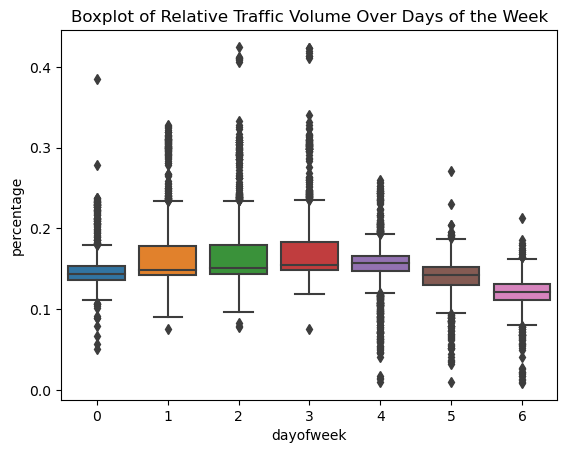

In [5]:
traffic_sum = traffic_bydayofweek.groupby(by=['streetID']).agg({'meanWeek': 'sum'}).reset_index()
week_plot = pd.merge(left=traffic_bydayofweek, right=traffic_sum, how='left', on=['streetID'])
week_plot['percentage'] = week_plot.apply(lambda row: (row['meanWeek_x']/row['meanWeek_y']), axis=1)
week_plot = week_plot.loc[week_plot['percentage'] <=0.8, :] # drop some outliers

sns.boxplot(x=week_plot['dayofweek'], y=week_plot['percentage']).set(title='Boxplot of Relative Traffic Volume Over Days of the Week')

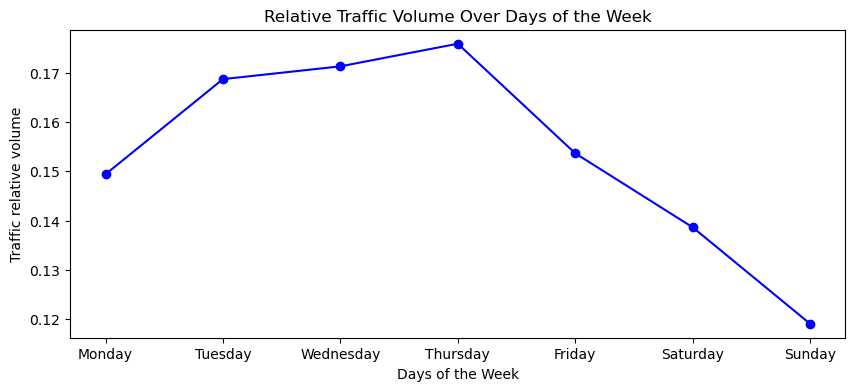

In [6]:
# plot traffic data by week
week_plot = week_plot.groupby(by=['dayofweek']).agg({'percentage': 'mean'}).reset_index()

color = 'blue'
figsize = (10, 4)

fig, ax = plt.subplots(figsize=figsize)
ax.plot(week_plot['dayofweek'], week_plot['percentage'], color=color, marker='o')
ax.set_xticks(ticks=[x for x in range(7)], labels=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
ax.set_xlabel('Days of the Week')
ax.set_ylabel('Traffic relative volume')
plt.title('Relative Traffic Volume Over Days of the Week')
plt.show()

### Average traffic volume by the hour of the day

In [7]:
traffic_byhour = traffic.groupby(by=['streetID', 'time']).agg({'traffic': ['mean', 'std', 'median', 'min', 'max']})
traffic_byhour.columns = traffic_byhour.columns.droplevel(0)
traffic_byhour = traffic_byhour.reset_index()
traffic_byhour['rangeHour'] = traffic_byhour.apply(lambda row: row['max'] - row['min'], axis=1)
traffic_byhour = traffic_byhour.rename(columns={'mean': 'meanHour', 'std': 'stdHour', 'median': 'medianHour', 'min': 'minHour', 'max': 'maxHour'})
traffic_byhour.head()
path = "../matched_data/crash_matched_data/traffic_byhour.csv"
traffic_byhour.to_csv(path)

[Text(0.5, 1.0, 'Boxplot of Relative Traffic Volume Over Hours of the Day')]

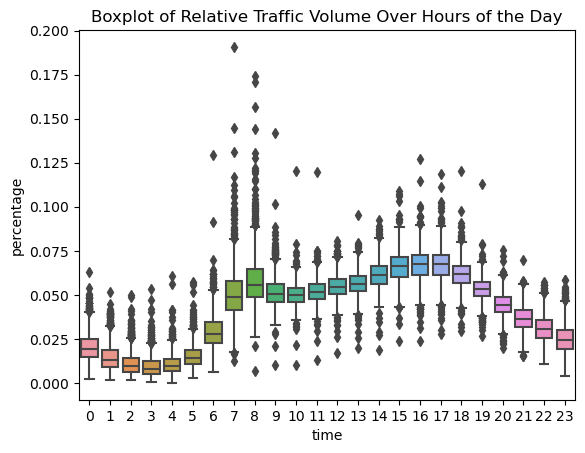

In [121]:
traffic_sum = traffic_byhour.groupby(by=['streetID']).agg({'meanHour': 'sum'}).reset_index()
hour_plot = pd.merge(left=traffic_byhour, right=traffic_sum, how='left', on=['streetID'])
hour_plot['percentage'] = hour_plot.apply(lambda row: (row['meanHour_x']/row['meanHour_y']), axis=1)

sns.boxplot(x=hour_plot['time'], y=hour_plot['percentage']).set(title='Boxplot of Relative Traffic Volume Over Hours of the Day')

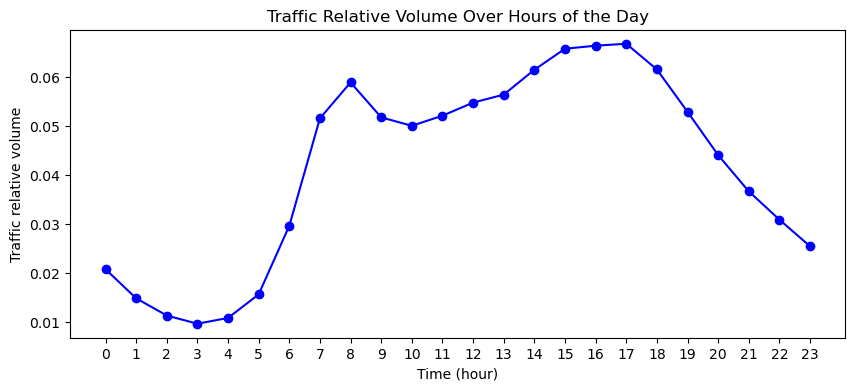

In [122]:
# plot traffic data by hour
hour_plot = hour_plot.groupby(by=['time']).agg({'percentage': 'mean'}).reset_index()

fig, ax = plt.subplots(figsize=figsize)
ax.plot(hour_plot['time'], hour_plot['percentage'], color=color, marker='o')
ax.set_xticks([x for x in range(24)])
ax.set_xlabel('Time (hour)')
ax.set_ylabel('Traffic relative volume')
plt.title('Traffic Relative Volume Over Hours of the Day')
plt.show()

### Average traffic volume by month

There is no obvious informtion by aggregating by month.

[Text(0.5, 1.0, 'Boxplot of Relative Traffic Volume Over Hours of the Day')]

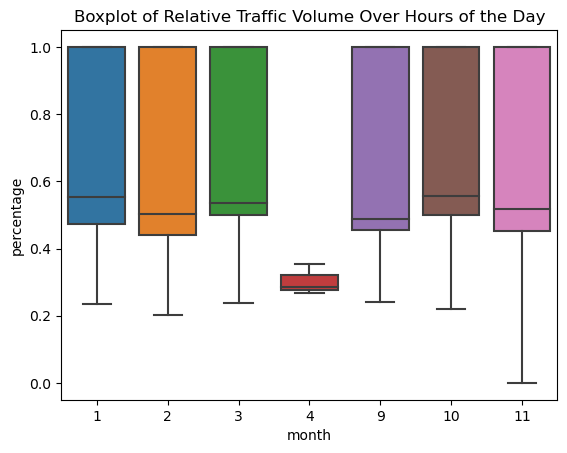

In [123]:
traffic_bymonth = traffic.groupby(by=['streetID', 'month']).agg({'traffic': ['mean', 'std', 'median', 'min', 'max']})
traffic_bymonth.columns = traffic_bymonth.columns.droplevel(0)
traffic_bymonth = traffic_bymonth.reset_index()
traffic_bymonth['rangeMonth'] = traffic_bymonth.apply(lambda row: row['max'] - row['min'], axis=1)
traffic_bymonth = traffic_bymonth.rename(columns={'mean': 'meanMonth', 'std': 'stdMonth', 'median': 'medianMonth', 'min': 'minMonth', 'max': 'maxMonth'})
traffic_bymonth.head()

traffic_sum = traffic_bymonth.groupby(by=['streetID']).agg({'meanMonth': 'sum'}).reset_index()
hour_plot = pd.merge(left=traffic_bymonth, right=traffic_sum, how='left', on=['streetID'])
hour_plot['percentage'] = hour_plot.apply(lambda row: (row['meanMonth_x']/row['meanMonth_y']), axis=1)

sns.boxplot(x=hour_plot['month'], y=hour_plot['percentage']).set(title='Boxplot of Relative Traffic Volume Over Hours of the Day')

## Collisions dataset aggregation
+ collisions dataset aggregate
    + total collision volume
        + by streetID (float): (collision volume/total collisions)
    + average collision 
        + by hour (float): average((hourly-collision volume/total collision on that segment))
            How much percentage of collisions happened on 
        + by the day of the week (float): average(collision volume/total collision on that segment)

In [2]:
collisions = pd.read_csv("../matched_data/crash_matched_data/collisions_matched.tsv", sep='\t')
collisions.columns

/var/folders/44/72pmvlr52d96w04q3bmj_jxr0000gn/T/ipykernel_88411/1904505440.py:1: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  collisions = pd.read_csv("../matched_data/crash_matched_data/collisions_matched.tsv", sep='\t')


Index(['collision_id', 'CRASH DATE', 'CRASH TIME', 'BOROUGH', 'ZIP CODE',
       'LATITUDE', 'LONGITUDE', 'LOCATION', 'ON STREET NAME',
       'CROSS STREET NAME', 'OFF STREET NAME', 'NUMBER OF PERSONS INJURED',
       'NUMBER OF PERSONS KILLED', 'NUMBER OF PEDESTRIANS INJURED',
       'NUMBER OF PEDESTRIANS KILLED', 'NUMBER OF CYCLIST INJURED',
       'NUMBER OF CYCLIST KILLED', 'NUMBER OF MOTORIST INJURED',
       'NUMBER OF MOTORIST KILLED', 'CONTRIBUTING FACTOR VEHICLE 1',
       'CONTRIBUTING FACTOR VEHICLE 2', 'CONTRIBUTING FACTOR VEHICLE 3',
       'CONTRIBUTING FACTOR VEHICLE 4', 'CONTRIBUTING FACTOR VEHICLE 5',
       'COLLISION_ID', 'VEHICLE TYPE CODE 1', 'VEHICLE TYPE CODE 2',
       'VEHICLE TYPE CODE 3', 'VEHICLE TYPE CODE 4', 'VEHICLE TYPE CODE 5',
       'coords', 'index_right', 'Roadway.Name', 'From', 'To', 'int1', 'int2',
       'zip1', 'zip2', 'll1', 'll2', 'streetID', 'lat1', 'long1', 'lat2',
       'long2'],
      dtype='object')

In [3]:
collisions['CRASH DATE'] = pd.to_datetime(collisions['CRASH DATE'])
collisions['dayofweek'] = collisions['CRASH DATE'].dt.dayofweek # Monday=0, Sunday=6.
collisions['CRASH HOUR'] = pd.to_datetime(collisions['CRASH TIME']).dt.hour # int64

### Total collision volume by streetID

In [4]:
# primary key: streetID
collisions_street = collisions.groupby(by=['streetID']).agg({'streetID': 'count'}) 
collisions_street = collisions_street.rename(columns={'streetID': 'total_collision'}).reset_index()

### Collision risk by hour

In [5]:
# primary key: streetID, CRASH HOUR
collisions_hour = collisions.groupby(by=['streetID', 'CRASH HOUR']).agg({'streetID': 'count'}) 
collisions_hour = collisions_hour.rename(columns={'streetID': 'total'}).reset_index()

# primary key: streetID, CRASH HOUR
collisions_hour = pd.merge(left=collisions_hour, right=collisions_street, how='left', on='streetID')
collisions_hour['collision by hour'] = collisions_hour.apply(lambda row: (row['total']/row['total_collision']), axis=1)
collisions_hour = collisions_hour.drop(columns=['total', 'total_collision'])
collisions_hour.head()

,streetID,CRASH HOUR,collision by hour
0,0.0,0,0.046809
1,0.0,1,0.017021
2,0.0,2,0.004255
3,0.0,3,0.012766
4,0.0,4,0.021277


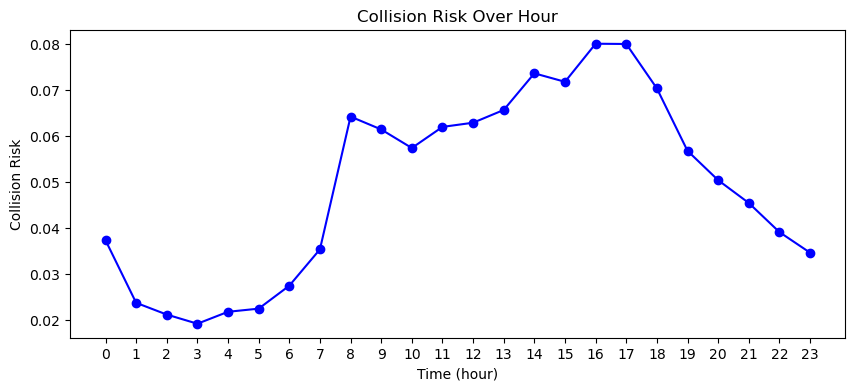

In [6]:
hour_plot = collisions_hour.groupby(by=['CRASH HOUR']).agg({'collision by hour': 'mean'}).reset_index()

color = 'blue'
figsize = (10, 4)

fig, ax = plt.subplots(figsize=figsize)
ax.plot(hour_plot['CRASH HOUR'], hour_plot['collision by hour'], color=color, marker='o')
ax.set_xticks([x for x in range(24)])
ax.set_xlabel('Time (hour)')
ax.set_ylabel('Collision Risk')
plt.title('Collision Risk Over Hour')
plt.show()

### Collision risk by days of the week

In [7]:
# primary key: streetID, dayofweek
collisions_dayweek = collisions.groupby(by=['streetID', 'dayofweek']).agg({'streetID': 'count'}) 
collisions_dayweek = collisions_dayweek.rename(columns={'streetID': 'total'}).reset_index()

# primary key: streetID, dayofweek
collisions_dayweek = pd.merge(left=collisions_dayweek, right=collisions_street, how='left', on='streetID')
collisions_dayweek['collision by day of week'] = collisions_dayweek.apply(lambda row: (row['total']/row['total_collision']), axis=1)
collisions_dayweek = collisions_dayweek.drop(columns=['total', 'total_collision'])
collisions_dayweek.head()

,streetID,dayofweek,collision by day of week
0,0.0,0,0.144681
1,0.0,1,0.157447
2,0.0,2,0.119149
3,0.0,3,0.204255
4,0.0,4,0.153191


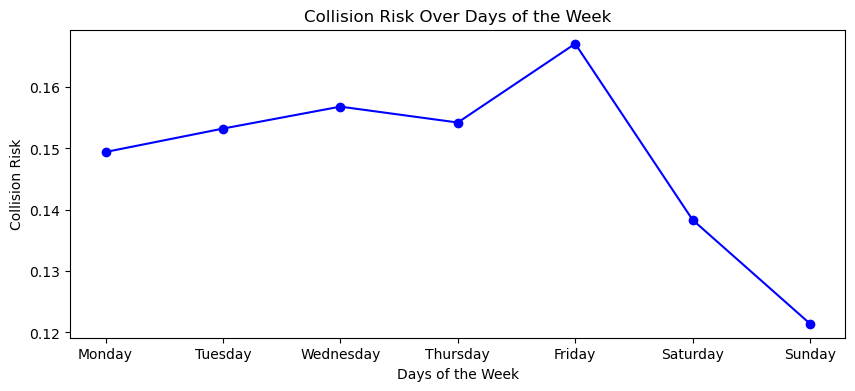

In [8]:
week_plot = collisions_dayweek.groupby(by=['dayofweek']).agg({'collision by day of week': 'mean'}).reset_index()

fig, ax = plt.subplots(figsize=figsize)
ax.plot(week_plot['dayofweek'], week_plot['collision by day of week'], color=color, marker='o')
ax.set_xticks(ticks=[x for x in range(7)], labels=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
ax.set_xlabel('Days of the Week')
ax.set_ylabel('Collision Risk')
plt.title('Collision Risk Over Days of the Week')
plt.show()